## Using Keras to build neural networks

In [55]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')

import matplotlib.pyplot as plt

from keras.datasets import mnist
np.random.seed(42)

In [56]:
#load MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

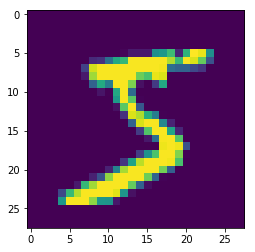

In [57]:
plt.imshow(X_train[0])

In [58]:
X_train.shape

(60000, 28, 28)

In [59]:
#dataset is 3D, so it will need to be flattened
pixels = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape(X_train.shape[0], pixels).astype('float32')
X_test = X_test.reshape(X_test.shape[0], pixels).astype('float32')

In [60]:
#normalize so all the values line between 0-1
X_train /= 255
X_test /= 255


In [30]:
y_train.shape

(60000,)

In [31]:
y_train[0]

5

In [52]:
#target is currently still a list on integers, but it needs to be categories, can do this using utils.to_category
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]


## Build a simple multi-layer perceptron model
#### The model is build sequentially, with layers added one at a time. We're only adding one hidden layer and an output layer for this first simple model, but we'll be adding more layers later
#### input_dims is the input dimensions, this only needs to be secified in the first layer
#### finding the best network topology for your needs usually comes down to a little trial and error, but you need a large enough netwrok to capture the structure of the problem

In [22]:
#we can now create a baseline model

def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(units = pixels, input_dim=pixels, kernel_initializer='normal', activation='relu'))
    model.add(Dense(units = num_classes, kernel_initializer='normal', activation='softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

#### The baseline model has one hidden layer. The hidden layer has the same number of neurons as there are inputs (28*28 pixels).
#### The Dense() class defines fully connected layers
#### The softmax activation function for the output layer output a probability value, so one of the classes (0-9) will be selected. 

In [23]:
# build the baseline model
model = baseline_model()

# Fit the model, over 10 epochs, with update every 200 images
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)

# Evaluate baseline model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
 - 5s - loss: 0.2796 - acc: 0.9203 - val_loss: 0.1421 - val_acc: 0.9579
Epoch 2/10
 - 4s - loss: 0.1097 - acc: 0.9684 - val_loss: 0.0932 - val_acc: 0.9717
Epoch 3/10
 - 4s - loss: 0.0719 - acc: 0.9786 - val_loss: 0.0779 - val_acc: 0.9773
Epoch 4/10
 - 4s - loss: 0.0498 - acc: 0.9858 - val_loss: 0.0684 - val_acc: 0.9803
Epoch 5/10
 - 4s - loss: 0.0361 - acc: 0.9898 - val_loss: 0.0643 - val_acc: 0.9799
Epoch 6/10
 - 4s - loss: 0.0262 - acc: 0.9929 - val_loss: 0.0604 - val_acc: 0.9808
Epoch 7/10
 - 4s - loss: 0.0192 - acc: 0.9956 - val_loss: 0.0647 - val_acc: 0.9808
Epoch 8/10
 - 4s - loss: 0.0153 - acc: 0.9962 - val_loss: 0.0568 - val_acc: 0.9821
Epoch 9/10
 - 4s - loss: 0.0106 - acc: 0.9978 - val_loss: 0.0589 - val_acc: 0.9817
Epoch 10/10
 - 4s - loss: 0.0076 - acc: 0.9987 - val_loss: 0.0660 - val_acc: 0.9790

#### Epochs refers to the number of iteractions through the dataset for the training process. And the batch_size sets the number of instances that are evaluated before the network weights are updated. 

## Build a CNN
#### This requires slightly different reshaping compared to the previous example

In [72]:
# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# reshape to be [samples][pixels][width][height]
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')

#and normalize
X_train /= 255
X_test /= 255

# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

X_train.shape

(60000, 1, 28, 28)

#### Conv2D() - 2D convolutional layer (for spatial convolution over images) filters is the dimensionality of the output space, kernel size is the width and height of the 2D convolution window (must be an odd integer), need to define the input shape for the first layer, need to define the activaton function
#### MaxPooling2D() is used to reduce the spatial dimensions of the output volumne
#### Dropout() helps with overfitting, sets a random fraction of the input units to 0 at each update during training. Form of regularization. 
#### Flatten() flattens the input
#### Need to change data format at the moment I think - should go and change the config file maybe? With TF backend I believe it defaults to channel last?

In [76]:
#create function to build model

def cnn_model():
    model = Sequential()
    model.add(Conv2D(filters = 32,kernel_size = (5,5), input_shape = (1,28,28), activation = 'relu', data_format = 'channels_first'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(units = 128, activation = 'relu'))
    model.add(Dense(units = num_classes, activation = 'softmax'))
    
    #compile model
    model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    
    return model

In [77]:
#build the actual model

model = cnn_model()

#fit the model, over 10 epochs, wit update every 200 images
model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 10, batch_size = 200, verbose = 2)

#evaluate model
scores = model.evaluate(X_test,y_test, verbose = 0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
 - 26s - loss: 0.2405 - acc: 0.9309 - val_loss: 0.0881 - val_acc: 0.9723
Epoch 2/10
 - 25s - loss: 0.0761 - acc: 0.9774 - val_loss: 0.0499 - val_acc: 0.9846
Epoch 3/10
 - 25s - loss: 0.0530 - acc: 0.9839 - val_loss: 0.0453 - val_acc: 0.9841
Epoch 4/10
 - 24s - loss: 0.0409 - acc: 0.9874 - val_loss: 0.0387 - val_acc: 0.9862
Epoch 5/10
 - 24s - loss: 0.0337 - acc: 0.9898 - val_loss: 0.0377 - val_acc: 0.9879
Epoch 6/10
 - 25s - loss: 0.0274 - acc: 0.9909 - val_loss: 0.0357 - val_acc: 0.9877
Epoch 7/10
 - 25s - loss: 0.0232 - acc: 0.9926 - val_loss: 0.0319 - val_acc: 0.9897
Epoch 8/10
 - 24s - loss: 0.0196 - acc: 0.9933 - val_loss: 0.0330 - val_acc: 0.9901
Epoch 9/10
 - 24s - loss: 0.0168 - acc: 0.9948 - val_loss: 0.0330 - val_acc: 0.9900
Epoch 10/10
 - 25s - loss: 0.0133 - acc: 0.9957 - val_loss: 0.0303 - val_acc: 0.9902
CNN Error: 0.98%


#### Our error rate has dropped to 0.98% with a CNN

## Building a larger CNN for classification with the MNIST dataset

In [80]:
#create function to build bigger model

def large_cnn():
    model = Sequential()
    model.add(Conv2D(filters = 32,kernel_size = (5,5), input_shape = (1,28,28), activation = 'relu', data_format = 'channels_first'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Conv2D(filters = 64, kernel_size = (5,5), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(units = 128, activation = 'relu'))
    model.add(Dense(units = 50, activation = 'relu'))
    model.add(Dense(units = num_classes, activation = 'softmax'))
    
    #compile model
    model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    
    return model
    

In [81]:
#build model
model = large_cnn()

#fit model, over 10 epochs, with update ever 200 images (batch szie = 200)
model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 10, batch_size = 200)

#evaluate model
scores = model.evaluate(X_test, y_test, verbose = 0)
print('Large CNN model error: %.2f%%' % (100-scores[1]*100))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 36s 608us/step - loss: 0.2873 - acc: 0.9121 - val_loss: 0.0699 - val_acc: 0.9776
Epoch 2/10
60000/60000 [==============================] - 35s 589us/step - loss: 0.0703 - acc: 0.9780 - val_loss: 0.0455 - val_acc: 0.9862
Epoch 3/10
60000/60000 [==============================] - 35s 591us/step - loss: 0.0488 - acc: 0.9847 - val_loss: 0.0408 - val_acc: 0.9863
Epoch 4/10
60000/60000 [==============================] - 36s 600us/step - loss: 0.0366 - acc: 0.9884 - val_loss: 0.0289 - val_acc: 0.9911
Epoch 5/10
60000/60000 [==============================] - 36s 604us/step - loss: 0.0308 - acc: 0.9903 - val_loss: 0.0267 - val_acc: 0.9926
Epoch 6/10
60000/60000 [==============================] - 37s 609us/step - loss: 0.0281 - acc: 0.9912 - val_loss: 0.0294 - val_acc: 0.9912
Epoch 7/10
60000/60000 [==============================] - 37s 610us/step - loss: 0.0223 - acc: 0.9929 - val_loss: 0.

#### Further improvement with this 'closer to state of the art' model. Error rate has dropped to 0.79%. Took a little longer to train, but nothing too bad, although small dataset. 